<a href="https://colab.research.google.com/github/mroshan454/Replicating-ViT-Research-Paper/blob/main/Replicating_The_ViT_Paper_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating The Vision Transformer Research Paper from Scratch

In this notebook , I will be attempting to replicate the 2020 Research paper:

 "AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE ,
Where the Vision Transformer (ViT) attains excellent results compared to state-of-the-art convolutional networks while requiring sub- stantially fewer computational resources to train.

The goal of machine learning research paper replicating is to turn a ML Research Paper into usable code.





For replicating this research paper , I'm using a custom dataset containing images facial expressions which are happy , sad and angry. The dataset name is FER-2013 which can be found on Kaggle.

What I'm using for this project is just 3 expressions only so that I can train the ViT Base model to classify these three facial expressions.


## 0. Importing required libraries

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


## 1. Get Data

In [2]:
import os
import zipfile

from pathlib import Path

import requests

#Setup path to data folder
data_path = Path("data/")
image_path = data_path / "happy_angry_sad"

#If image folder does'nt exist , download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Did not find {image_path} directory , creating one....")
  image_path.mkdir(parents=True, exist_ok=True)

#Download happy , angry , sad data
with open(data_path / "happy_angry_sad.zip","wb") as f:
  request = requests.get("https://github.com/mroshan454/Replicating-ViT-Research-Paper/raw/main/happy_angry_sad.zip")
  print("Downloading data...")
  f.write(request.content)

#Unzip happy,angry,sad data
with zipfile.ZipFile(data_path / "happy_angry_sad.zip","r") as zip_ref:
  print("Unzipping happy_angry_sad data...")
  zip_ref.extractall(image_path)

#Remove zip file
os.remove(data_path / "happy_angry_sad.zip")


Did not find data/happy_angry_sad directory , creating one....
Unzipping happy_angry_sad data...


In [3]:
#Setup train and test directory
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir , test_dir

(PosixPath('data/happy_angry_sad/train'),
 PosixPath('data/happy_angry_sad/test'))

## 2. Create datasets and dataloaders

Now we'll turn the data into PyTorch `Datasets` and `Dataloader's`

In [4]:
from torchvision import datasets , transforms

#Create simple transforms
data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

#Use image folder to create dataset
train_data = datasets.ImageFolder(root=train_dir, #Target folder of images
                                 transform=data_transform, #Transforms to perform on data (images)
                                 target_transform=None) #Transforms to perform on labels (if necessary)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
print(f"Train Data:\n{train_data}\nTest Data:\n{test_data}")

Train Data:
Dataset ImageFolder
    Number of datapoints: 16040
    Root location: data/happy_angry_sad/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 3979
    Root location: data/happy_angry_sad/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=3)
               ToTensor()
           )


In [5]:
#Get class names as a list
class_names = train_data.classes
class_names

['angry', 'happy', 'sad']

In [6]:
#Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'angry': 0, 'happy': 1, 'sad': 2}

In [7]:
#Check lengths
len(train_data), len(test_data)

(16040, 3979)

data/happy_angry_sad/train/angry/Training_61652087.jpg
angry
Random Image Path: data/happy_angry_sad/train/angry/Training_61652087.jpg
Image Class : angry
Image Height : 48
Image Width : 48


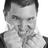

In [8]:
import random
from PIL import Image

#Set seed
#random.seed(42)

# 1.Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from the path name ( the image class is the name of the directory where the image is stored )
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

#5. Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image Class : {image_class}")
print(f"Image Height : {img.height}")
print(f"Image Width : {img.width}")
img

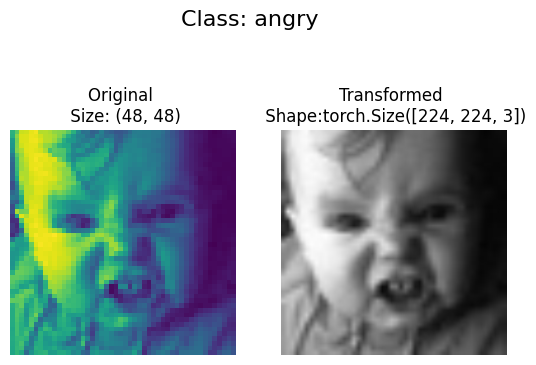

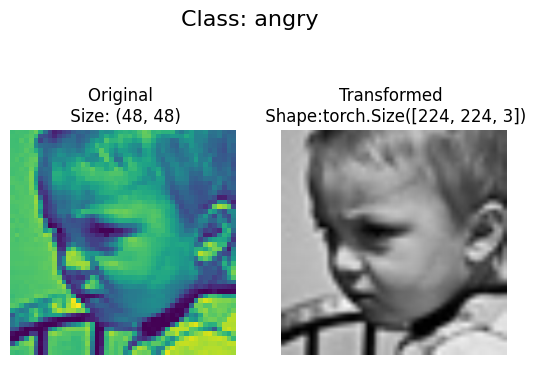

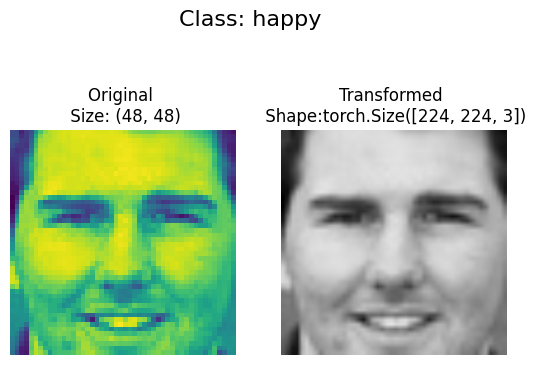

In [9]:
import numpy as np
import matplotlib.pyplot as plt
def plot_transformed_images(image_paths:list,transform,n=3,seed=42):
  """
  Selects random images from a path of image and loads/transforms
  them then plots the original vs the transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig ,ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size: {f.size}")
      ax[0].axis(False)

      #Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) #Note we will need to change shape for matplotlib (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Shape:{transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

In [10]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)
train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b7a4b759a50>,
 <torch.utils.data.dataloader.DataLoader at 0x7b7a4db880d0>)

## 3. Replicating ViT : Overview

Rather than looking at whole machine learning paper , we can make it more understandable by breaking it down into smaller blocks.

* **Inputs** - What goes into the model?(in our case,image tensors)
* **Outputs** - What comes out of the model/layer/block? (In our case, we want the model to output image classification labels)
* **Layers** - Takes an input , manipulates it with a function eg:Self-Attention.
* **Blocks** - A collection of layers.
* **Model or Architecture** - A collection of blocks.

### 3.1 ViT Figure 1
<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/Fig.1.VIT.png?raw=true" width=900 alt="figure 1 from the original vision transformer paper"/>


**Figure 1 Explained Visually:**

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/1.png?raw=true" width=900 alt="figure 1 explained visually"/>

### 3.2 Four Equations

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/Four%20Equations.png?raw=true" width=900 alt="four equations"/>

These are the four equations that is used throughout this research paper.


#### **Equation 1: Explained Visually**

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/2.png?raw=true" width=900 alt="equation 1 explained visually"/>

The Equation 1 shows that the images are converted into patches , and linearly embedd each other together and one extra learnable class embedding is added , and after that each position embeddings are given to each patches including the Extra Learnable class embedding.

We are using 1-D Patch Embeddings because , there is no significant performance gain from using the advanced 2D- Aware position embeddings.(Appendix D.4)

The Equation is converted into a pseudocode later which we can turn it into PyTorch code.


#### **Equation 2 & 3: Explained Visually**

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/3.png?raw=true" width=900 alt="equation 3 explained visually"/>

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/4.png?raw=true" width=900 alt="equation 4 explained visually"/>

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

#### **Equation 4: Explained Visually**

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/5.png?raw=true" width=900 alt="equation 5 explained visually"/>

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches ( $\mathrm{z}_0^0=\mathrm{x}_{\text {class }}$ ), whose state at the output of the Transformer encoder ( $\mathrm{z}_L^0$ ) serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.


* MLP = Multilayer Perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine tuning time


## **Table 1**


| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

* ViT-Base , ViT-Large and ViT-Huge are all different sizes of the same model architecture.

* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Head - the number of multi-head self-attention

For Starting we will be Replicating ViT Base at First

## 4. Converting the Equation 1 into PyTorch code:

### Split Data into Patches and Creating Class , Position and Patch Embedding.

### 4.1 Calculate input and output shapes by hand

**Equation 1:**

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathrm{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathrm{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape : $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^2 \cdot C\right)}$
* H = Height
* W = Width
* C = Color Channels
* P = Patch Size
* N = number of patches = (Height * Width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)


In [11]:
#Creating Example values
height = 224
width = 224
color_channels = 3
patch_size = 16

#Calculate the number of patches
num_patches = int((height*width) / patch_size**2)
num_patches


196

In [12]:
#Input shape
embedding_layer_input_shape = (height,width,color_channels)

#Output shape
embedding_layer_output_shape = (num_patches,patch_size**2 * color_channels)

print(f"Input Shape :{embedding_layer_input_shape}")
print(f"Output Shape: {embedding_layer_output_shape}")

Input Shape :(224, 224, 3)
Output Shape: (196, 768)


### 4.2. Turning  a single image into Patches

Let's visualise , visualise , visualise

In [13]:
# Get a batch of images
image_batch , label_batch = next(iter(train_dataloader))

#Get a single image and label from the batch
image , label = image_batch[0] , label_batch[0]


#View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

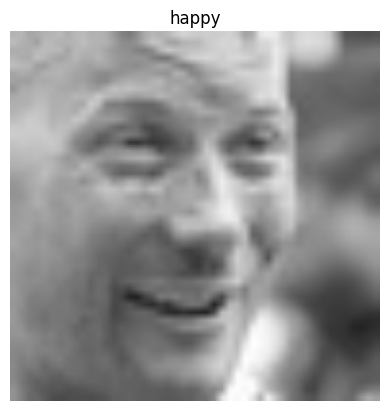

In [14]:
# View a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [15]:
image.shape

torch.Size([3, 224, 224])

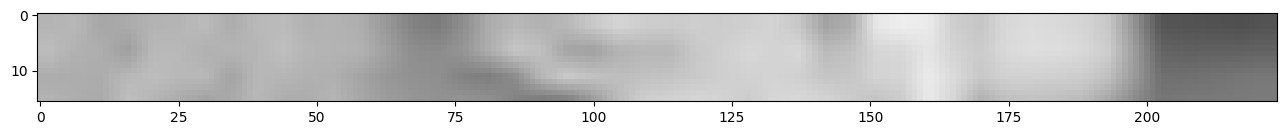

In [16]:
#Get the top row of the image
image_permuted = image.permute(1,2,0) #Converting the image to color channels last (H,W,C)

#Index to plot the top row of pixels
patch_size = 16  #In the research paper
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])


Number of patches per row/column : 14.0 
 Patch Size 16 pixels x 16 pixels


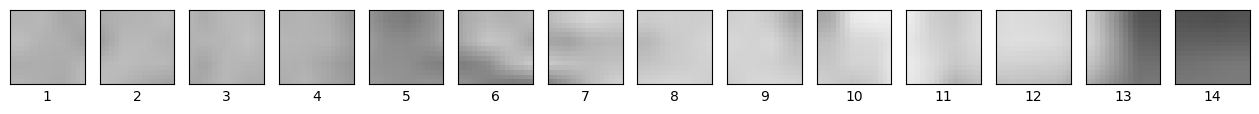

In [17]:
#Plot the top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0 , "Image size must be divisible by patch size"
print(f"Number of patches per row/column : {num_patches} \n Patch Size {patch_size} pixels x {patch_size} pixels")

#Create a series of Subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size//patch_size,#One column for each patch,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size,patch_size))

#Iterate through the number of patches in the top row
for i , patch in enumerate(range(0,img_size,patch_size)):
    axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:]);
    axs[i].set_xlabel(i+1) #Set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row/column : 14.0 
 Patch Size 16 pixels x 16 pixels 
 Total Patches : 196.0


Text(0.5, 0.98, 'happy->Patchified Image')

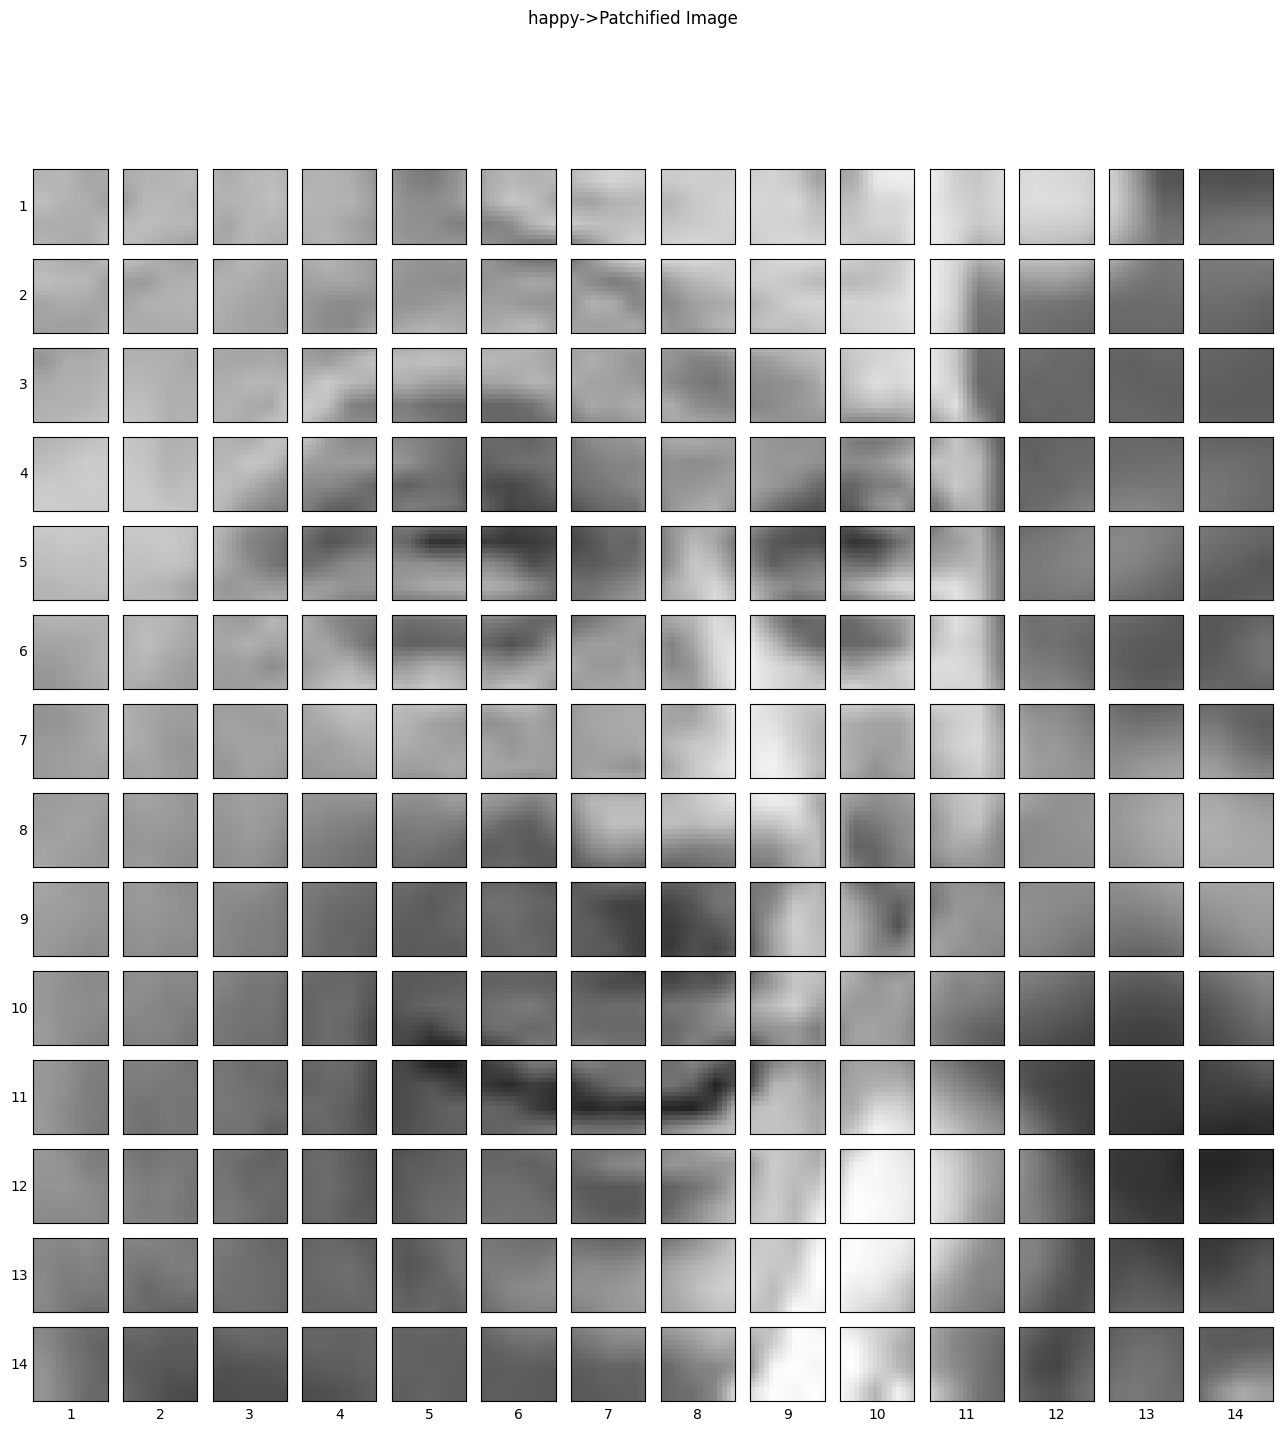

In [18]:
#Creating whole image plot in patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0 , "Image size must be divisible by patch size"
print(f"Number of patches per row/column : {num_patches} \n Patch Size {patch_size} pixels x {patch_size} pixels \n Total Patches : {num_patches*num_patches}")

#Create a series of Subplots
fig, axs = plt.subplots(nrows=img_size//patch_size,
                        ncols=img_size//patch_size,#One column for each patch,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size,patch_size))

#Loop through height and width
for i , patch_height in enumerate(range(0,img_size,patch_size)):
  for j , patch_width in enumerate(range(0,img_size,patch_size)):
    #Plot the permuted image on the different axes
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,#Iterate through the height dimension
                                   patch_width:patch_width+patch_size,#Iterate through the width dimension
                                   :])
    #Setup label information for each subplot(patch)
    axs[i,j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment="right",
                        verticalalignment="center")
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()
# Setup a title for the plot
fig.suptitle(f"{class_names[label]}->Patchified Image")

### 4.3 Creating image patches and turning them into patch embeddings

Rather than using all the steps above , we can turn our image into patch embeddings in a single step by using `torch.nn.Conv2d()` and setting the stride and kernel_size to the `patch_size`.


In [19]:
#Create a Conv2d layer to turn image into patches of learnable feature maps(embeddings)
from torch import nn

#Set the patch_size
patch_size = 16

#Creating a conv2d layer with the hyperparameters given in the ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768 , # The D size in Table 1
                   stride=patch_size,
                   kernel_size=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

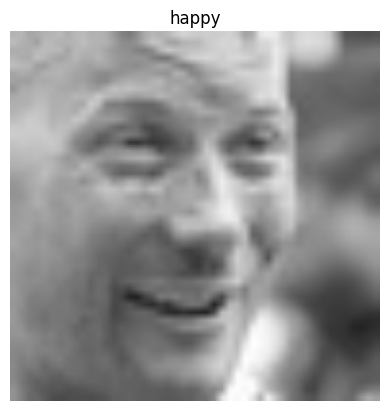

In [20]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

Now we need to pass the image through the convolutional layer

In [21]:
#Pass the image through the conv2d layer
image_out_of_conv = conv2d(image.unsqueeze(0))#Adding a batch dimension -> (batch_size, color_channels , height , width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now it is in the shape -> 1, 768, 14,14 , but we need to flatten the image and that is our next step

In [22]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes:[250, 228, 142, 754, 104]


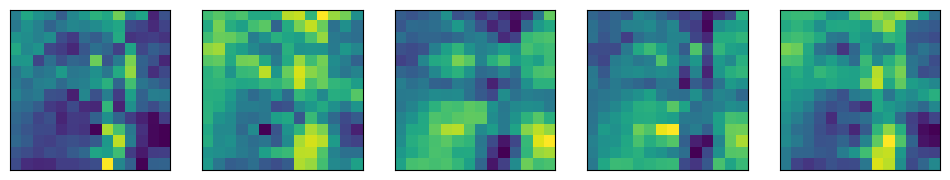

In [23]:
#Plot the random convolutional feature maps(embeddings)
import random
random_indexes = random.sample(range(0,768),k=5)
print(f"Showing random convolutional feature maps from indexes:{random_indexes}")

#Create a plot
fig , axs  = plt.subplots(nrows=1,ncols=5,figsize=(12,12))

#Plot the random image feature maps
for i,idx in enumerate(random_indexes):
   image_conv_feature_map = image_out_of_conv[:,idx,:,:]
   axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) #remove batch dimension , and remove from grad tracking/switch to numpy for matplotlib
   axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])

In [24]:
#Get single feature map in tensor form
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map

tensor([[[0.3471, 0.3464, 0.3310, 0.3459, 0.2727, 0.3176, 0.3068, 0.3670,
          0.4351, 0.3647, 0.4335, 0.4084, 0.3913, 0.2156],
         [0.3272, 0.3212, 0.3192, 0.2740, 0.2929, 0.3136, 0.2642, 0.2578,
          0.3773, 0.3890, 0.4020, 0.1997, 0.2068, 0.1970],
         [0.3325, 0.3605, 0.3545, 0.3728, 0.2740, 0.2716, 0.3163, 0.2552,
          0.2337, 0.3705, 0.4208, 0.1923, 0.1828, 0.1776],
         [0.3813, 0.3853, 0.3418, 0.2760, 0.2269, 0.1609, 0.1985, 0.2558,
          0.2870, 0.2291, 0.3687, 0.1938, 0.2280, 0.2297],
         [0.3534, 0.3563, 0.3166, 0.2582, 0.3163, 0.2765, 0.1834, 0.3384,
          0.2619, 0.2095, 0.3594, 0.2291, 0.2398, 0.1856],
         [0.2938, 0.3497, 0.3067, 0.3507, 0.2511, 0.2357, 0.2936, 0.2583,
          0.4877, 0.2677, 0.4296, 0.2270, 0.1778, 0.1771],
         [0.2835, 0.3188, 0.2988, 0.2784, 0.3202, 0.2852, 0.3018, 0.3428,
          0.4575, 0.3143, 0.3916, 0.3247, 0.2775, 0.2714],
         [0.3022, 0.2890, 0.2765, 0.2308, 0.1995, 0.1596, 0.2641, 0.2

### 4.4 Flattening the image patch

In [25]:
print(f"{image_out_of_conv.shape} -> [batch_size,embedding_dim,feature_map_height,feature_map_width]")


torch.Size([1, 768, 14, 14]) -> [batch_size,embedding_dim,feature_map_height,feature_map_width]


Want:(batch_size,number_of_patches,embedding_dim)

In [26]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original Image Shape:torch.Size([3, 224, 224])
Image shape after passing through Conv2d : torch.Size([1, 768, 14, 14])
Image Shape after flattening the image out of conv2d:torch.Size([1, 768, 196])


torch.Size([1, 196, 768])

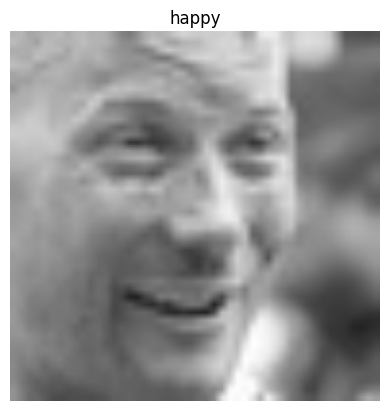

In [27]:
#Putting all together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);
print(f"Original Image Shape:{image.shape}")

#Turn image into feature shape
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image shape after passing through Conv2d : {image_out_of_conv.shape}")

#Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Image Shape after flattening the image out of conv2d:{image_out_of_conv_flattened.shape}")

#Reshaping the Flattened Feature map -> [batch_size , num_patches , embedding_size]
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
image_out_of_conv_flattened_reshaped.shape

####  Now we want to get a visualisation of single flattened feature map and plotting them visually

In [28]:
#Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)
single_flattened_feature_map.shape

torch.Size([1, 196])

(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

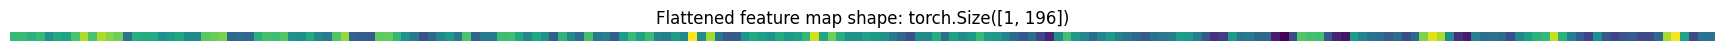

In [29]:
#Plot the above visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [30]:
single_flattened_feature_map , single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[0.3471, 0.3464, 0.3310, 0.3459, 0.2727, 0.3176, 0.3068, 0.3670, 0.4351,
          0.3647, 0.4335, 0.4084, 0.3913, 0.2156, 0.3272, 0.3212, 0.3192, 0.2740,
          0.2929, 0.3136, 0.2642, 0.2578, 0.3773, 0.3890, 0.4020, 0.1997, 0.2068,
          0.1970, 0.3325, 0.3605, 0.3545, 0.3728, 0.2740, 0.2716, 0.3163, 0.2552,
          0.2337, 0.3705, 0.4208, 0.1923, 0.1828, 0.1776, 0.3813, 0.3853, 0.3418,
          0.2760, 0.2269, 0.1609, 0.1985, 0.2558, 0.2870, 0.2291, 0.3687, 0.1938,
          0.2280, 0.2297, 0.3534, 0.3563, 0.3166, 0.2582, 0.3163, 0.2765, 0.1834,
          0.3384, 0.2619, 0.2095, 0.3594, 0.2291, 0.2398, 0.1856, 0.2938, 0.3497,
          0.3067, 0.3507, 0.2511, 0.2357, 0.2936, 0.2583, 0.4877, 0.2677, 0.4296,
          0.2270, 0.1778, 0.1771, 0.2835, 0.3188, 0.2988, 0.2784, 0.3202, 0.2852,
          0.3018, 0.3428, 0.4575, 0.3143, 0.3916, 0.3247, 0.2775, 0.2714, 0.3022,
          0.2890, 0.2765, 0.2308, 0.1995, 0.1596, 0.2641, 0.2617, 0.3235, 0.2125,
          0.3024

We have turned our 2D image into learnable 1 dimensional Linear Learnable Embedding , now we need to put everything together into a PyTorch Module.

### 4.5 Turning the ViT Patch Embedding Layer into a PyTorch Module

We need to make all the above into a PyTorch module by subclassing nn.Module

For that we are following the steps below:

1. Create a class called `PatchEmbedding` which subclasses nn.Module (For reusability and structure).
2. Initialise the parameters with `in_channels` = 3 , `patch_size`= 16 and `embedding_dim`=768($D$ from ViT Base Table 1).
3. Create a Layer to turn an image into Patches
4. Create a Layer to flatten the patches
5. Define a forward() method to take an input and pass it through the layers in 3 and 4.
6. Check if the Output shape is the required output shape of the ViT Architecture.



In [31]:
# 1. Create a class named PatchEmbedding which subclass nn.Module
class PatchEmbedding(nn.Module):
  """This turns a 2D image into 1-Dimensional Learnable Patch Embedding

     Args: in_channels(int):Number of color channels for the input image(Default-3),
     patch_size(int): The size of the patches to convert the image into(Default-16),
     embedding_dim(int): The size of embedding to turn the image into (Default-768)

  """
  #2. Initialise the classes with appropriate values
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
      super().__init__()

      #3. Create a layer to turn an image into patch
      self.patcher = nn.Conv2d(in_channels=in_channels,
                              out_channels=embedding_dim,
                              kernel_size=patch_size,
                              stride=patch_size,
                              padding=0)

      #4. Create a layer to flatten the image
      self.flatten = nn.Flatten(start_dim=2,  # only flatten the feature map dimensions into a single vector
                                end_dim=3)

  #5. Define Forward method
  def forward(self,x):
      #Create assertion to check the inputs are the correct shape
      image_resolution = x.shape[-1]
      assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

      #Perform the forward pass
      x_patched = self.patcher(x)
      x_flattened = self.flatten(x_patched)
      #6. Check if the output is the required Output shape for ViT architecture
      return x_flattened.permute(0,2,1)

In [32]:
#Trying the above in a single image

#Create an instance of patch_embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
#Pass a single image through
print(f"Input Shape:{image.shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output Shape:{patch_embedded_image.shape}")



Input Shape:torch.Size([3, 224, 224])
Output Shape:torch.Size([1, 196, 768])


Now we have replicated the patch embedding , and the next steps is to create the learnable class embedding and position embeddings which will complete the Equation 1 from the ViT Paper.

### 4.6 Creating the class token embedding

In this section we need to prepend a learnable embedding to the sequence of embedded patches.

In [33]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.6980, -0.6411,  0.4471,  ..., -0.0926, -0.0369,  0.5848],
         [-0.7206, -0.6427,  0.4544,  ..., -0.0911, -0.0395,  0.5686],
         [-0.7109, -0.6544,  0.4658,  ..., -0.0885, -0.0126,  0.5870],
         ...,
         [-0.3400, -0.3069,  0.2274,  ..., -0.0239, -0.0447,  0.3114],
         [-0.4197, -0.3681,  0.2930,  ..., -0.0776, -0.0269,  0.3614],
         [-0.4445, -0.3700,  0.3349,  ..., -0.0102, -0.0378,  0.3855]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [34]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size,embedding_dimension

(1, 768)

In [35]:
#Create a class token embedding as a learnable parameter that share the same size as the embedding dimension(D)
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                           requires_grad=True)
#Show the first 10 Examples
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [40]:
#Add the class token embedding to the front of patch embeddings
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image),
                                                  dim=1) #Number of patch dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embedding with class token prepend shape:{patch_embedded_image_with_class_embedding.shape} ->(batch_size,class_token+number_of_patches,embedding_dim)")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6980, -0.6411,  0.4471,  ..., -0.0926, -0.0369,  0.5848],
         [-0.7206, -0.6427,  0.4544,  ..., -0.0911, -0.0395,  0.5686],
         ...,
         [-0.3400, -0.3069,  0.2274,  ..., -0.0239, -0.0447,  0.3114],
         [-0.4197, -0.3681,  0.2930,  ..., -0.0776, -0.0269,  0.3614],
         [-0.4445, -0.3700,  0.3349,  ..., -0.0102, -0.0378,  0.3855]]],
       grad_fn=<CatBackward0>)
Sequence of patch embedding with class token prepend shape:torch.Size([1, 197, 768]) ->(batch_size,class_token+number_of_patches,embedding_dim)


We have successfully created the class token and prepend it to the patch embedding , Now we need to create position embedding and add them to the sequence of patch embeddings.

### 4.7 Create Position Embeddings

We need to create 1D learnable position embeddings and add them to sequence of patch embeddings.

In [41]:
#View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding , patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.6980, -0.6411,  0.4471,  ..., -0.0926, -0.0369,  0.5848],
          [-0.7206, -0.6427,  0.4544,  ..., -0.0911, -0.0395,  0.5686],
          ...,
          [-0.3400, -0.3069,  0.2274,  ..., -0.0239, -0.0447,  0.3114],
          [-0.4197, -0.3681,  0.2930,  ..., -0.0776, -0.0269,  0.3614],
          [-0.4445, -0.3700,  0.3349,  ..., -0.0102, -0.0378,  0.3855]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [51]:
#Calculate the Number of Patches
number_of_patches = int((height*width)/patch_size**2)

#Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

#Create the 1D learnable 1D Position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

position_embedding , position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [52]:
#Adding the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Shape of Patch and Position embedding:{patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3020, 0.3589, 1.4471,  ..., 0.9074, 0.9631, 1.5848],
         [0.2794, 0.3573, 1.4544,  ..., 0.9089, 0.9605, 1.5686],
         ...,
         [0.6600, 0.6931, 1.2274,  ..., 0.9761, 0.9553, 1.3114],
         [0.5803, 0.6319, 1.2930,  ..., 0.9224, 0.9731, 1.3614],
         [0.5555, 0.6300, 1.3349,  ..., 0.9898, 0.9622, 1.3855]]],
       grad_fn=<AddBackward0>)
Shape of Patch and Position embedding:torch.Size([1, 197, 768])


### 4.8 Combining all Together to complete the Equation 1

We can do by following the steps below:

1. Set the patch size = 16.
2. Getting a single image , print and store its shape.
3. Add a batch dimension to the single image so it's comparable with our `PatchEmbedding` layer.

4. Creating a PatchEmbedding layer  with a patch_size=16 and embedding_dim=768 (from Table 1 for ViT-Base).
5. Passing the single image through the PatchEmbedding layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding.
7. Prepending the class token embedding to the patch embeddings.
8. Creating a position embedding.
9. Adding the position embedding to the class token and patch embeddings.

In [63]:
#1. Set the patch size
patch_size = 16

#2. Getting a single image , print and store it's shape
print(f"Image Tensor Shape:{image.shape}")
height , width = image.shape[1] , image.shape[2]

#3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Image with additional batch dimension shape:{x.shape}")

#4. Create Patch Embedding Layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                          patch_size=patch_size,
                          embedding_dim=768)
#5. Passing the image through the patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch Embedding Shape:{patch_embedding}")

#6. Create the class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                           requires_grad=True)
print(f"Class Token embedding shape: {class_token.shape}")

#7. Prepend class token embedding to patch embedding
patch_embedding_with_class_token = torch.cat((class_token,patch_embedding),
                                             dim=1)
print(f"Patch Embedding with class token shape:{patch_embedding_with_class_token.shape}")

#8. Create position embedding
number_of_patches = int((height*width)/patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) #Make sure its learnable

#9.Add position embedding with patch embedding with class token
patch_and_position_embedding = patch_embedding_with_class_token + position_embedding
print(f"Patch and Position embedding shape:{patch_and_position_embedding.shape}")

Image Tensor Shape:torch.Size([3, 224, 224])
Image with additional batch dimension shape:torch.Size([1, 3, 224, 224])
Patch Embedding Shape:tensor([[[0.3790, 0.0862, 0.3666,  ..., 0.2894, 0.0995, 0.3465],
         [0.4180, 0.0922, 0.3627,  ..., 0.2519, 0.1115, 0.3772],
         [0.4064, 0.0973, 0.3854,  ..., 0.2422, 0.1129, 0.3778],
         ...,
         [0.1547, 0.0110, 0.2055,  ..., 0.1340, 0.0467, 0.1963],
         [0.2410, 0.0460, 0.2304,  ..., 0.1542, 0.0566, 0.2377],
         [0.2453, 0.0319, 0.2542,  ..., 0.2007, 0.0138, 0.2575]]],
       grad_fn=<PermuteBackward0>)
Class Token embedding shape: torch.Size([1, 1, 768])
Patch Embedding with class token shape:torch.Size([1, 197, 768])
Patch and Position embedding shape:torch.Size([1, 197, 768])


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.3790, 1.0862, 1.3666,  ..., 1.2894, 1.0995, 1.3465],
         [1.4180, 1.0922, 1.3627,  ..., 1.2519, 1.1115, 1.3772],
         ...,
         [1.1547, 1.0110, 1.2055,  ..., 1.1340, 1.0467, 1.1963],
         [1.2410, 1.0460, 1.2304,  ..., 1.1542, 1.0566, 1.2377],
         [1.2453, 1.0319, 1.2542,  ..., 1.2007, 1.0138, 1.2575]]],
       grad_fn=<AddBackward0>)